In [9]:
# general functionality
import pandas as pd
import numpy as np
import math as mt
import os
import re

# plotting
import geopandas
import matplotlib.pyplot as plt
import matplotlib.colors

# machine learning modules
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# (Business) Questions:
1. Which city is more expensive: Seattle or Boston?
2. What influences the price?
3. Are there specific areas within the cities that are more expensive?

# Functions I want to use

In [3]:
# Get NaN values for given column
getNaNs = lambda x: x.isna().sum()

# Get Value counts get value counts (especially for categorical columns)
getValueCounts = lambda x: x.value_counts()

# Transform string prices to float
getFloatPrices = lambda x: float(re.findall("\d+\.\d+", x)[0])

# Get city by zip code
def getCity(zip_code):
    if(zip_code.startswith("0") == True):
        return "Boston"
    elif(zip_code.startswith("9") == True):
        return "Seattle"

# Get NaN percentages for both cities
getNaNPercentageBoston = lambda x: x/b_df.shape[0]
getNaNPercentageSeattle = lambda x: x/s_df.shape[0]

# Gather data (read csv-files that contain listings)

In [5]:
# Listings data
b_df = pd.read_csv("b_listings.csv")
s_df = pd.read_csv("s_listings.csv")
# shapefile data
seattle = geopandas.read_file("./data/City_Clerk_Neighborhoods.shp")
seattle = seattle.to_crs(epsg=4326)
boston = geopandas.read_file("./data/City_of_Boston_Boundary.shp")
boston = boston.to_crs(epsg=4326)

# 1. Which city is more expensive: Seattle or Boston?

In [6]:
# Show rows and columns for both data sets
print(F"Boston Listings Shape: {b_df.shape}")
print(F"Seatle Listings Shape: {s_df.shape}")

Boston Listings Shape: (3585, 95)
Seatle Listings Shape: (3818, 92)


In [7]:
b_cols = b_df.columns
s_cols = s_df.columns

# Check if there are any non matching columns
non_matching_cols = [list(set(b_cols).difference(s_cols))]
print(non_matching_cols)
b_df["source_city"] = "Boston"
s_df["source_city"] = "Seattle"
listings_df = pd.concat([b_df, s_df])
print(listings_df.shape)

[['house_rules', 'access', 'interaction']]
(7403, 96)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


In [10]:
# Tranforms price column from string to float
listings_df["price"] = listings_df["price"].apply(getFloatPrices)
listings_df.head(3)

,access,accommodates,amenities,availability_30,availability_365,availability_60,availability_90,bathrooms,bed_type,bedrooms,...,space,square_feet,state,street,summary,thumbnail_url,transit,weekly_price,xl_picture_url,zipcode
0,"You will have access to 2 bedrooms, a living r...",4,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",0,0,0,0,1.5,Real Bed,2.0,...,The house has an open and cozy feel at the sam...,NaN,MA,"Birch Street, Boston, MA 02131, United States","Cozy, sunny, family home. Master bedroom high...",https://a2.muscache.com/im/pictures/c0842db1-e...,"The bus stop is 2 blocks away, and frequent. B...",NaN,https://a2.muscache.com/im/pictures/c0842db1-e...,02131
1,Apt has one more bedroom (which I use) and lar...,2,"{TV,Internet,""Wireless Internet"",""Air Conditio...",26,359,54,84,1.0,Real Bed,1.0,...,Small but cozy and quite room with a full size...,NaN,MA,"Pinehurst Street, Boston, MA 02131, United States",Charming and quiet room in a second floor 1910...,https://a1.muscache.com/im/pictures/39327812/d...,Plenty of safe street parking. Bus stops a few...,$400.00,https://a1.muscache.com/im/pictures/39327812/d...,02131
2,"I am living in the apartment during your stay,...",2,"{TV,""Cable TV"",""Wireless Internet"",""Air Condit...",19,319,46,61,1.0,Real Bed,1.0,...,"Come stay with a friendly, middle-aged guy in ...",NaN,MA,"Ardale St., Boston, MA 02131, United States","Come stay with a friendly, middle-aged guy in ...",https://a2.muscache.com/im/pictures/6ae8335d-9...,"PUBLIC TRANSPORTATION: From the house, quick p...",$395.00,https://a2.muscache.com/im/pictures/6ae8335d-9...,02131


In [11]:
# Group average price by zip code
zip_average_price = pd.DataFrame(listings_df.groupby('zipcode')['price'].mean()).sort_values(by='price', ascending=False)
zip_average_price["zipcode"] = zip_average_price.index
zip_average_price

,price,zipcode
zipcode,,
02108 02111,334.000000,02108 02111
02110,274.076923,02110
02142,270.000000,02142
02210,260.106667,02210
02111,253.535354,02111
...,...,...
02134-1704,80.000000,02134-1704
99\n98122,67.000000,99\n98122
02472,60.000000,02472


In [12]:
# Create and fill city column based on zip codes
zip_average_price["city"] = zip_average_price["zipcode"].apply(getCity)

# Check if the grouping worked properly
set(zip_average_price["city"])

{'Boston', 'Seattle'}

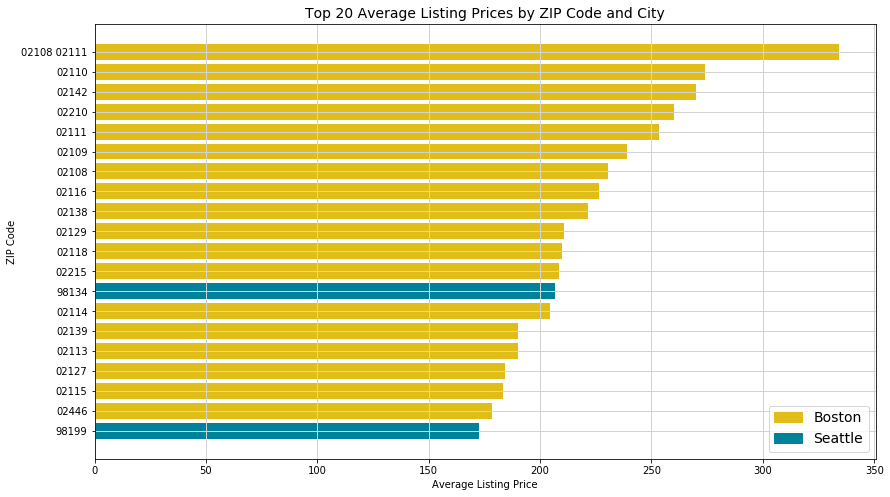

In [14]:
# Plot average prices by zip code

colors = {"Boston": '#E0BD18', "Seattle": '#00839A'}

fig, ax = plt.subplots(figsize=(14, 8))
fig = plt.barh(zip_average_price["zipcode"].head(20), zip_average_price["price"].head(20) , color=[colors[i] for i in zip_average_price['city']])
plt.xlabel("Average Listing Price")
plt.ylabel("ZIP Code")
plt.title("Top 20 Average Listing Prices by ZIP Code and City", fontsize=14) 
ax.grid(color='lightgrey', linestyle='-', linewidth=1)
ax.set_facecolor("white")
ax.invert_yaxis()
     
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels, fontsize=14)

plt.show()


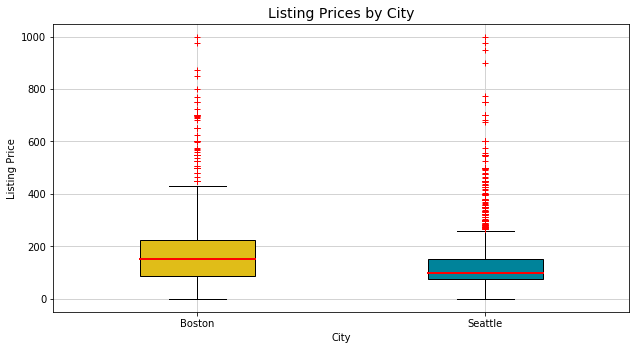

In [16]:
# Create box plots grouped by city

fig = plt.figure(figsize =(4, 4)) 
ax = fig.add_axes([0, 0, 2, 1]) 

d1 =  listings_df.loc[listings_df["city"] == "Boston"]["price"].tolist()
d2 = listings_df.loc[listings_df["city"] == "Seattle"]["price"].tolist()

medianprops = dict(linestyle='-', linewidth=2, color='r')
bp0 = ax.boxplot(d1, positions=[0.25], sym='r+', notch=False, showfliers=True, showbox=True, showcaps=True, widths = 0.2, patch_artist=True, medianprops=medianprops) 
bp1 = ax.boxplot(d2, positions=[0.75], sym='r+', notch=False, showfliers=True, showbox=True, showcaps=True, widths = 0.2, patch_artist=True, medianprops=medianprops) 


for box in bp0['boxes']:
    box.set(facecolor = "#E0BD18")
for box in bp1['boxes']:
    box.set(facecolor = "#00839A" )

plt.xlabel("City")
plt.ylabel("Listing Price")
plt.title("Listing Prices by City", fontsize=14) 
ax.grid(color='lightgrey', linestyle='-', linewidth=1)
ax.set_xticklabels(["Boston", "Seattle"])
ax.set_facecolor("white")
plt.xlim(0, 1)
plt.savefig('price_comparison.png')

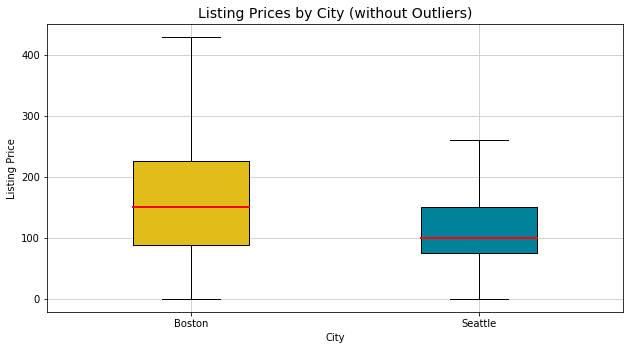

In [17]:
# Create box plots grouped by city (without outliers)

fig = plt.figure(figsize =(4, 4)) 
  
# Creating axes instance 
ax = fig.add_axes([0, 0, 2, 1]) 

d1 =  listings_df.loc[listings_df["city"] == "Boston"]["price"].tolist()
d2 = listings_df.loc[listings_df["city"] == "Seattle"]["price"].tolist()

medianprops = dict(linestyle='-', linewidth=2, color='r')
bp0 = ax.boxplot(d1, positions=[0.25], notch=False, showfliers=False, showbox=True, showcaps=True, widths = 0.2, patch_artist=True, medianprops=medianprops) 
bp1 = ax.boxplot(d2, positions=[0.75], notch=False, showfliers=False, showbox=True, showcaps=True, widths = 0.2, patch_artist=True, medianprops=medianprops) 

for box in bp0['boxes']:
    box.set(facecolor = "#E0BD18")
for box in bp1['boxes']:
    box.set(facecolor = "#00839A" )

plt.xlabel("City")
plt.ylabel("Listing Price")
plt.title("Listing Prices by City (without Outliers)", fontsize=14) 
ax.grid(color='lightgrey', linestyle='-', linewidth=1)
ax.set_xticklabels(["Boston", "Seattle"])
ax.set_facecolor("white")
plt.xlim(0, 1)
plt.savefig('price_comparison_wo_outliers.png')


In [157]:
# Print measures median and mean for each city

In [147]:
listings_df.loc[listings_df["city"] == "Boston"]["price"].median()

150.0

In [148]:
listings_df.loc[listings_df["city"] == "Boston"]["price"].mean()

172.05678793256433

In [149]:
listings_df.loc[listings_df["city"] == "Seattle"]["price"].median()

100.0

In [150]:
listings_df.loc[listings_df["city"] == "Seattle"]["price"].mean()

127.78976377952756

# Boston

In [19]:
# printing column + value for index = 0 to scan them manually before starting further analysis
for col in b_df.columns:
    print(F"{col}: {b_df[col][0]}")
    print(F"")

id: 12147973

listing_url: https://www.airbnb.com/rooms/12147973

scrape_id: 20160906204935

last_scraped: 2016-09-07

name: Sunny Bungalow in the City

summary: Cozy, sunny, family home.  Master bedroom high ceilings. Deck, garden with hens, beehives & play structure.   Short walk to charming village with  attractive stores, groceries & local restaurants. Friendly neighborhood. Access public transportation.

space: The house has an open and cozy feel at the same time.  The living room has a flat screen TV.  The kitchen has all you need for cooking.  We prefer you buy your food but can use the organic oils, herbs, etc.   The yard can be seen from sitting room and when the weather allows, the yard is a place children can lose themselves in a safe way.  We have 2 bee hives, 6 hens fenced in (sometimes they get out of their coop area & into the yard), 2 rabbits in a hutch and play structure.

description: Cozy, sunny, family home.  Master bedroom high ceilings. Deck, garden with hens, bee

In [20]:
# Checking for columns with high NaN count
b_nas = pd.DataFrame(b_df.apply(getNaNs), columns=["count"]).sort_values(by="count", ascending=False)
b_nas["na_percentage"] = b_nas["count"].apply(getNaNPercentageBoston)
b_nas = b_nas.loc[b_nas["na_percentage"] >= 0.3]
b_nas

,count,na_percentage
neighbourhood_group_cleansed,3585,1.000000
has_availability,3585,1.000000
jurisdiction_names,3585,1.000000
license,3585,1.000000
square_feet,3529,0.984379
monthly_price,2697,0.752301
weekly_price,2693,0.751185
security_deposit,2243,0.625662
notes,1975,0.550907
interaction,1554,0.433473


In [21]:
# create a list with columns of interest
columns_of_interest = [
"id",
"latitude",
"longitude",
"price",
"zipcode",
"bathrooms",
"bedrooms",
"beds",
"bed_type",
"cancellation_policy",
"amenities",
"guests_included",
"instant_bookable",
"host_has_profile_pic",
"host_verifications",
"number_of_reviews",
"host_listings_count",
"host_total_listings_count",
"host_identity_verified",
"review_scores_accuracy",
"review_scores_location",
"review_scores_value",
"review_scores_checkin",
"review_scores_communication",
"review_scores_cleanliness",
"review_scores_rating",
"reviews_per_month",
]

In [22]:
# checking df for different datatypes
b_df = b_df[columns_of_interest]
b_df.dtypes

id                               int64
latitude                       float64
longitude                      float64
price                           object
zipcode                         object
bathrooms                      float64
bedrooms                       float64
beds                           float64
bed_type                        object
cancellation_policy             object
amenities                       object
guests_included                  int64
instant_bookable                object
host_has_profile_pic            object
host_verifications              object
number_of_reviews                int64
host_listings_count              int64
host_total_listings_count        int64
host_identity_verified          object
review_scores_accuracy         float64
review_scores_location         float64
review_scores_value            float64
review_scores_checkin          float64
review_scores_communication    float64
review_scores_cleanliness      float64
review_scores_rating     

# 2. What influences the price?


## ...in Boston?

In [23]:
# transform price from string to float using the getFloatPrices column
b_df["price"] = b_df["price"].apply(getFloatPrices)

In [24]:
# prining number of na entries columns and percentage
for col in columns_of_interest:
    nas = b_df[col].isna().sum()
    perc = nas/b_df.shape[0]
    print(F"{col}: {nas} ({perc} percent of column are NaN entries)")

id: 0 (0.0 percent of column are NaN entries)
latitude: 0 (0.0 percent of column are NaN entries)
longitude: 0 (0.0 percent of column are NaN entries)
price: 0 (0.0 percent of column are NaN entries)
zipcode: 38 (0.010599721059972107 percent of column are NaN entries)
bathrooms: 14 (0.003905160390516039 percent of column are NaN entries)
bedrooms: 10 (0.002789400278940028 percent of column are NaN entries)
beds: 9 (0.002510460251046025 percent of column are NaN entries)
bed_type: 0 (0.0 percent of column are NaN entries)
cancellation_policy: 0 (0.0 percent of column are NaN entries)
amenities: 0 (0.0 percent of column are NaN entries)
guests_included: 0 (0.0 percent of column are NaN entries)
instant_bookable: 0 (0.0 percent of column are NaN entries)
host_has_profile_pic: 0 (0.0 percent of column are NaN entries)
host_verifications: 0 (0.0 percent of column are NaN entries)
number_of_reviews: 0 (0.0 percent of column are NaN entries)
host_listings_count: 0 (0.0 percent of column are N

In [25]:
# cleaning df from na values in columns of interest
print(b_df.shape[0])
b_df_cleaned = b_df[columns_of_interest].dropna()
print(b_df_cleaned.shape[0])
b_df_cleaned = b_df_cleaned.reset_index()
b_df_cleaned

3585
2712


,index,id,latitude,longitude,price,zipcode,bathrooms,bedrooms,beds,bed_type,...,host_total_listings_count,host_identity_verified,review_scores_accuracy,review_scores_location,review_scores_value,review_scores_checkin,review_scores_communication,review_scores_cleanliness,review_scores_rating,reviews_per_month
0,1,3075044,42.286241,-71.134374,65.0,02131,1.0,1.0,1.0,Real Bed,...,1,t,10.0,9.0,9.0,10.0,10.0,9.0,94.0,1.30
1,2,6976,42.292438,-71.135765,65.0,02131,1.0,1.0,1.0,Real Bed,...,1,t,10.0,9.0,10.0,10.0,10.0,9.0,98.0,0.47
2,4,7651065,42.284512,-71.136258,79.0,02131,1.5,1.0,2.0,Real Bed,...,1,t,10.0,9.0,10.0,10.0,10.0,10.0,99.0,2.25
3,5,12386020,42.291690,-71.131893,75.0,02131,1.0,1.0,1.0,Real Bed,...,2,t,10.0,9.0,10.0,10.0,10.0,10.0,100.0,1.70
4,6,5706985,42.281390,-71.131190,100.0,02131,1.0,1.0,2.0,Real Bed,...,5,t,10.0,9.0,9.0,10.0,10.0,10.0,90.0,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2707,3574,14743129,42.303305,-71.161940,68.0,02467,1.0,1.0,1.0,Real Bed,...,2,f,8.0,10.0,8.0,8.0,6.0,8.0,80.0,1.00
2708,3575,5280827,42.382681,-71.085720,69.0,02143,1.0,1.0,1.0,Real Bed,...,28,t,8.0,8.0,7.0,9.0,10.0,7.0,70.0,0.33
2709,3578,14536322,42.370741,-71.114914,85.0,02138,1.0,1.0,1.0,Real Bed,...,4,f,10.0,10.0,10.0,10.0,10.0,10.0,100.0,2.00
2710,3580,8373729,42.380968,-71.083795,69.0,02143,1.0,1.0,1.0,Real Bed,...,28,t,10.0,8.0,9.0,10.0,10.0,10.0,90.0,0.34


In [26]:
# checking non-numeric columns for unique features
b_df_features = b_df_cleaned[b_df_cleaned.columns.difference(["index", "id", "latitude", "longitude"])]

for col in b_df_features:
    if(b_df_features[col].dtype == "object"):
        print(F"{col}: {len(set(b_df_features[col]))}")

amenities: 2395
bed_type: 5
cancellation_policy: 4
host_has_profile_pic: 2
host_identity_verified: 2
host_verifications: 52
instant_bookable: 2
zipcode: 40


In [27]:
# print unique entries in bed_type column
bed_type_set = set( b_df_features["bed_type"])

print(len(bed_type_set))

for entry in bed_type_set:
      print(entry)

5
Real Bed
Pull-out Sofa
Airbed
Couch
Futon


In [28]:
# print unique entries in cancellation_policy column
cancellation_policy_set = set( b_df_features["cancellation_policy"])

print(len(cancellation_policy_set))

for entry in cancellation_policy_set:
      print(entry)

4
flexible
strict
moderate
super_strict_30


In [29]:
# print unique entries in host_has_profile_pic column
host_has_profile_pic_set = set( b_df_features["host_has_profile_pic"])

print(len(host_has_profile_pic_set))

for entry in host_has_profile_pic_set:
      print(entry)

2
f
t


In [30]:
# print unique entries in host_identity_verified column
host_identity_verified_set = set( b_df_features["host_identity_verified"])

print(len(host_identity_verified_set))

for entry in host_identity_verified_set:
      print(entry)

2
f
t


In [31]:
# print unique entries in instant_bookable column
instant_bookable_set = set( b_df_features["instant_bookable"])

print(len(instant_bookable_set))

for entry in instant_bookable_set:
      print(entry)

2
f
t


In [32]:
# print unique entries in amnities column
amnity_list = []

for i in range(0, b_df_features.shape[0]):
    amnity_row = b_df_features["amenities"][i].split(",")
    for element in amnity_row:
        element = element.replace('"', '').replace('{', '').replace('}', '')
        amnity_list.append(element)

amnity_set = set(amnity_list)

print(len(amnity_set))
        
amnity_set.remove("")
amnity_set.remove("translation missing: en.hosting_amenity_49")
amnity_set.remove("translation missing: en.hosting_amenity_50")

print(len(amnity_set))

for entry in amnity_set:
      print(entry)

46
43
Internet
Dog(s)
Lock on Bedroom Door
Essentials
Pets Allowed
Cat(s)
Carbon Monoxide Detector
Hangers
Wheelchair Accessible
Pool
Smoke Detector
Safety Card
First Aid Kit
Paid Parking Off Premises
Buzzer/Wireless Intercom
Washer
Heating
Iron
Washer / Dryer
Kitchen
Free Parking on Street
Doorman
24-Hour Check-in
Hot Tub
Laptop Friendly Workspace
Air Conditioning
Wireless Internet
Pets live on this property
Cable TV
Smoking Allowed
Dryer
Other pet(s)
Indoor Fireplace
Family/Kid Friendly
Hair Dryer
TV
Elevator in Building
Fire Extinguisher
Shampoo
Gym
Free Parking on Premises
Breakfast
Suitable for Events


In [33]:
# print unique entries in host_verification column
host_verifications_list = []

for i in range(0, b_df_features.shape[0]):
    host_verifications_row = b_df_features["host_verifications"][i].split(",")
    for element in host_verifications_row:
        element = element.replace('[', '').replace(']', '').replace("'", '').strip()
        host_verifications_list.append(element)
        
host_verifications_set = set(host_verifications_list)

print(len(host_verifications_set))

for entry in host_verifications_set:
      print(entry)

13
weibo
phone
google
jumio
manual_online
kba
facebook
manual_offline
sent_id
amex
reviews
linkedin
email


In [34]:
# print unique entries in zipcode column
zip_code_set = set( b_df_features["zipcode"])

print(len(zip_code_set))

for entry in zip_code_set:
      print(entry)

40
02108
02130
02119
02134
02141
02111
02120
02210
02143
02128
02126
02110
02129
02132
02186
02115
02446
02467
02116
02138
02135
02142
02124
02118
02109
02114
02125
02113
02127
02136
02108 02111
02134-1704
02445
02215
02122
02131
02163
02121
02145
02139


In [35]:
# get all numeric columns and append them to a list
num_cols = []

for col in b_df_features.columns:
    if(b_df_features[col].dtype == "object"):
        continue
    else:
        print(b_df_features[col].dtype)
        num_cols.append(col)

float64
float64
float64
int64
int64
int64
int64
float64
float64
float64
float64
float64
float64
float64
float64
float64


In [36]:
# create dummie variables for the chosen non numeric columns and fill them with 0

non_numeric_cols = [] 

for element in list(amnity_set):
    non_numeric_cols.append(F"{element}")
    b_df_features[F"amnity_{element}"] = 0
    
for element in list(host_verifications_set):
    non_numeric_cols.append(F"{element}")
    b_df_features[F"hv_{element}"] = 0
    
for element in list(zip_code_set):
    non_numeric_cols.append(F"{element}")
    b_df_features[F"zipcode_{element}"] = 0

for element in list(bed_type_set):
    non_numeric_cols.append(F"{element}")
    b_df_features[F"bt_{element}"] = 0
    
for element in list(cancellation_policy_set):
    non_numeric_cols.append(F"{element}")
    b_df_features[F"cp_{element}"] = 0
    
for element in list(host_has_profile_pic_set):
    non_numeric_cols.append(F"{element}")
    b_df_features[F"hpc_{element}"] = 0
    
for element in list(host_identity_verified_set):
    non_numeric_cols.append(F"{element}")
    b_df_features[F"hiv_{element}"] = 0
    
for element in list(instant_bookable_set):
    non_numeric_cols.append(F"{element}")
    b_df_features[F"ib_{element}"] = 0
    

b_df_features

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,guests_included,host_has_profile_pic,host_identity_verified,host_listings_count,...,cp_flexible,cp_strict,cp_moderate,cp_super_strict_30,hpc_f,hpc_t,hiv_f,hiv_t,ib_f,ib_t
0,"{TV,Internet,""Wireless Internet"",""Air Conditio...",1.0,Real Bed,1.0,1.0,moderate,0,t,t,1,...,0,0,0,0,0,0,0,0,0,0
1,"{TV,""Cable TV"",""Wireless Internet"",""Air Condit...",1.0,Real Bed,1.0,1.0,moderate,1,t,t,1,...,0,0,0,0,0,0,0,0,0,0
2,"{Internet,""Wireless Internet"",""Air Conditionin...",1.5,Real Bed,1.0,2.0,flexible,1,t,t,1,...,0,0,0,0,0,0,0,0,0,0
3,"{""Cable TV"",""Wireless Internet"",""Air Condition...",1.0,Real Bed,1.0,1.0,flexible,1,t,t,2,...,0,0,0,0,0,0,0,0,0,0
4,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",1.0,Real Bed,1.0,2.0,strict,1,t,t,5,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2707,"{""Wireless Internet"",Kitchen,""Free Parking on ...",1.0,Real Bed,1.0,1.0,moderate,1,t,f,2,...,0,0,0,0,0,0,0,0,0,0
2708,"{Internet,""Wireless Internet"",""Air Conditionin...",1.0,Real Bed,1.0,1.0,strict,1,t,t,28,...,0,0,0,0,0,0,0,0,0,0
2709,"{TV,Internet,""Wireless Internet"",""Air Conditio...",1.0,Real Bed,1.0,1.0,strict,1,t,f,4,...,0,0,0,0,0,0,0,0,0,0
2710,"{Internet,""Wireless Internet"",""Air Conditionin...",1.0,Real Bed,1.0,1.0,strict,1,t,t,28,...,0,0,0,0,0,0,0,0,0,0


In [38]:
# go over dummy columns and fill with 1 if the value is found in the original column
for col in b_df_features.iloc[:, 24:]:
    
    if "amnity" in col: 
        print(col)
        for i in range(0, b_df_features.shape[0]):
            if col[7:] in b_df_features["amenities"][i]:
                b_df_features[col][i] = 1
            else:
                b_df_features[col][i] = 0
    elif "zipcode" in col:
        print(col)
        for i in range(0, b_df_features.shape[0]):
            if col[8:] in b_df_features["zipcode"][i]:
                b_df_features[col][i] = 1
            else:
                b_df_features[col][i] = 0
                
    elif "hv_" in col:
        print(col)
        for i in range(0, b_df_features.shape[0]):
            if col[3:] in b_df_features["host_verifications"][i]:
                b_df_features[col][i] = 1
            else:
                b_df_features[col][i] = 0
                
    elif "bt_" in col:
        print(col)
        for i in range(0, b_df_features.shape[0]):
            if col[3:] in b_df_features["bed_type"][i]:
                b_df_features[col][i] = 1
            else:
                b_df_features[col][i] = 0                
                
    elif "cp_" in col:
        print(col)
        for i in range(0, b_df_features.shape[0]):
            if col[3:] in b_df_features["cancellation_policy"][i]:
                b_df_features[col][i] = 1
            else:
                b_df_features[col][i] = 0               
                
    elif "hpc_" in col:
        print(col)
        for i in range(0, b_df_features.shape[0]):
            if col[4:] in b_df_features["host_has_profile_pic"][i]:
                b_df_features[col][i] = 1
            else:
                b_df_features[col][i] = 0
                                
    elif "hiv_" in col:
        print(col)
        for i in range(0, b_df_features.shape[0]):
            if col[4:] in b_df_features["host_identity_verified"][i]:
                b_df_features[col][i] = 1
            else:
                b_df_features[col][i] = 0
                
    elif "ib_" in col:
        print(col)
        for i in range(0, b_df_features.shape[0]):
            if col[3:] in b_df_features["instant_bookable"][i]:
                b_df_features[col][i] = 1
            else:
                b_df_features[col][i] = 0

amnity_Internet


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


amnity_Dog(s)
amnity_Lock on Bedroom Door
amnity_Essentials
amnity_Pets Allowed
amnity_Cat(s)
amnity_Carbon Monoxide Detector
amnity_Hangers
amnity_Wheelchair Accessible
amnity_Pool
amnity_Smoke Detector
amnity_Safety Card
amnity_First Aid Kit
amnity_Paid Parking Off Premises
amnity_Buzzer/Wireless Intercom
amnity_Washer
amnity_Heating
amnity_Iron
amnity_Washer / Dryer
amnity_Kitchen
amnity_Free Parking on Street
amnity_Doorman
amnity_24-Hour Check-in
amnity_Hot Tub
amnity_Laptop Friendly Workspace
amnity_Air Conditioning
amnity_Wireless Internet
amnity_Pets live on this property
amnity_Cable TV
amnity_Smoking Allowed
amnity_Dryer
amnity_Other pet(s)
amnity_Indoor Fireplace
amnity_Family/Kid Friendly
amnity_Hair Dryer
amnity_TV
amnity_Elevator in Building
amnity_Fire Extinguisher
amnity_Shampoo
amnity_Gym
amnity_Free Parking on Premises
amnity_Breakfast
amnity_Suitable for Events
hv_weibo


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


hv_phone
hv_google
hv_jumio
hv_manual_online
hv_kba
hv_facebook
hv_manual_offline
hv_sent_id
hv_amex
hv_reviews
hv_linkedin
hv_email
zipcode_02108


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


zipcode_02130
zipcode_02119
zipcode_02134
zipcode_02141
zipcode_02111
zipcode_02120
zipcode_02210
zipcode_02143
zipcode_02128
zipcode_02126
zipcode_02110
zipcode_02129
zipcode_02132
zipcode_02186
zipcode_02115
zipcode_02446
zipcode_02467
zipcode_02116
zipcode_02138
zipcode_02135
zipcode_02142
zipcode_02124
zipcode_02118
zipcode_02109
zipcode_02114
zipcode_02125
zipcode_02113
zipcode_02127
zipcode_02136
zipcode_02108 02111
zipcode_02134-1704
zipcode_02445
zipcode_02215
zipcode_02122
zipcode_02131
zipcode_02163
zipcode_02121
zipcode_02145
zipcode_02139
bt_Real Bed


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


bt_Pull-out Sofa
bt_Airbed
bt_Couch
bt_Futon
cp_flexible


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


cp_strict
cp_moderate
cp_super_strict_30
hpc_f


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


hpc_t
hiv_f


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


hiv_t
ib_f


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ib_t


In [40]:
# choose only numeric columns to add them to the data that is used for training

nums = []
non_nums = []

for col in b_df_features.columns:
    if(b_df_features[col].dtype == "object"):
        non_nums.append(col)
    else:
        nums.append(col)

In [41]:
b_df_features_numeric = b_df_features[nums]
b_df_features_numeric

,bathrooms,bedrooms,beds,guests_included,host_listings_count,host_total_listings_count,number_of_reviews,price,review_scores_accuracy,review_scores_checkin,...,cp_flexible,cp_strict,cp_moderate,cp_super_strict_30,hpc_f,hpc_t,hiv_f,hiv_t,ib_f,ib_t
0,1.0,1.0,1.0,0,1,1,36,65.0,10.0,10.0,...,0,0,1,0,0,1,0,1,0,1
1,1.0,1.0,1.0,1,1,1,41,65.0,10.0,10.0,...,0,0,1,0,0,1,0,1,1,0
2,1.5,1.0,2.0,1,1,1,29,79.0,10.0,10.0,...,1,0,0,0,0,1,0,1,1,0
3,1.0,1.0,1.0,1,2,2,8,75.0,10.0,10.0,...,1,0,0,0,0,1,0,1,1,0
4,1.0,1.0,2.0,1,5,5,57,100.0,10.0,10.0,...,0,1,0,0,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2707,1.0,1.0,1.0,1,2,2,1,68.0,8.0,8.0,...,0,0,1,0,0,1,1,0,1,0
2708,1.0,1.0,1.0,1,28,28,6,69.0,8.0,9.0,...,0,1,0,0,0,1,0,1,0,1
2709,1.0,1.0,1.0,1,4,4,2,85.0,10.0,10.0,...,0,1,0,0,0,1,1,0,0,1
2710,1.0,1.0,1.0,1,28,28,4,69.0,10.0,10.0,...,0,1,0,0,0,1,0,1,0,1


In [42]:
#Split into explanatory and response variables
X = b_df_features_numeric.loc[:, b_df_features_numeric.columns != 'price']
y = b_df_features_numeric['price']
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state=90) 
# Fit model
lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)
# Predict data
y_test_preds = lm_model.predict(X_test) 
# Score predictions
y_test_preds = lm_model.predict(X_test)
r2_test = r2_score(y_test, y_test_preds) 
print(r2_test)
rmse_test = mt.sqrt(mean_squared_error(y_test, y_test_preds))
print(rmse_test)

0.6233168978782384
65.14422983002454


In [94]:
# create df with correlations with price
price_correlation = pd.DataFrame(b_df_features_numeric.corr()["price"])

In [98]:
# check for features with a positive correlation with a PCC greater than 0.1

positive_correlation = []

positive_correlation_values = []

for i in price_correlation.index.tolist():
    if(price_correlation["price"][i] > 0.1):
        positive_correlation.append(i)
        positive_correlation_values.append(price_correlation["price"][i])
print(positive_correlation)

['bathrooms', 'bedrooms', 'beds', 'guests_included', 'host_listings_count', 'host_total_listings_count', 'price', 'review_scores_cleanliness', 'review_scores_location', 'review_scores_rating', 'amnity_Pool', 'amnity_Buzzer/Wireless Intercom', 'amnity_Washer', 'amnity_Iron', 'amnity_Kitchen', 'amnity_Doorman', 'amnity_24-Hour Check-in', 'amnity_Air Conditioning', 'amnity_Cable TV', 'amnity_Dryer', 'amnity_Indoor Fireplace', 'amnity_Family/Kid Friendly', 'amnity_Hair Dryer', 'amnity_TV', 'amnity_Elevator in Building', 'amnity_Gym', 'hv_manual_online', 'hv_manual_offline', 'zipcode_02111', 'zipcode_02210', 'zipcode_02116', 'zipcode_02118', 'zipcode_02114', 'bt_Real Bed', 'cp_strict', 'cp_super_strict_30']


In [99]:
positive_correlation_df = pd.DataFrame({'feature': positive_correlation,'corr': positive_correlation_values}).sort_values(by="corr", ascending=False)
positive_correlation_df

,feature,corr
6,price,1.000000
1,bedrooms,0.542274
2,beds,0.514556
23,amnity_TV,0.338654
3,guests_included,0.330211
18,amnity_Cable TV,0.325205
0,bathrooms,0.309218
21,amnity_Family/Kid Friendly,0.289577
17,amnity_Air Conditioning,0.277204
24,amnity_Elevator in Building,0.257680


In [100]:
# check for features with a negative correlation with a PCC smaller than -0.1

negative_correlation =  []

negative_correlation_values = []

for i in price_correlation.index.tolist():
    if(price_correlation["price"][i] < -0.1):
        negative_correlation.append(i)
        negative_correlation_values.append(price_correlation["price"][i])
print(negative_correlation)

['number_of_reviews', 'reviews_per_month', 'amnity_Lock on Bedroom Door', 'amnity_Cat(s)', 'amnity_Free Parking on Premises', 'zipcode_02134', 'zipcode_02135', 'zipcode_02124', 'zipcode_02125', 'bt_Futon', 'cp_flexible']


In [101]:
negative_correlation_df = pd.DataFrame({'feature': negative_correlation,'corr': negative_correlation_values}).sort_values(by="corr", ascending=True)
negative_correlation_df

,feature,corr
2,amnity_Lock on Bedroom Door,-0.201528
10,cp_flexible,-0.192701
1,reviews_per_month,-0.160856
5,zipcode_02134,-0.145071
4,amnity_Free Parking on Premises,-0.133425
8,zipcode_02125,-0.130016
7,zipcode_02124,-0.125326
0,number_of_reviews,-0.108942
6,zipcode_02135,-0.104016
3,amnity_Cat(s),-0.103640


In [102]:
new_features = positive_correlation + negative_correlation
len(new_features)

47

In [49]:
# Testing with reduced features
b_df_reduced_features = b_df_features_numeric[new_features]
b_df_reduced_features

,bathrooms,bedrooms,beds,guests_included,host_listings_count,host_total_listings_count,price,review_scores_cleanliness,review_scores_location,review_scores_rating,...,reviews_per_month,amnity_Lock on Bedroom Door,amnity_Cat(s),amnity_Free Parking on Premises,zipcode_02134,zipcode_02135,zipcode_02124,zipcode_02125,bt_Futon,cp_flexible
0,1.0,1.0,1.0,0,1,1,65.0,9.0,9.0,94.0,...,1.30,1,0,0,0,0,0,0,0,0
1,1.0,1.0,1.0,1,1,1,65.0,9.0,9.0,98.0,...,0.47,1,0,1,0,0,0,0,0,0
2,1.5,1.0,2.0,1,1,1,79.0,10.0,9.0,99.0,...,2.25,0,0,0,0,0,0,0,0,1
3,1.0,1.0,1.0,1,2,2,75.0,10.0,9.0,100.0,...,1.70,0,1,1,0,0,0,0,0,1
4,1.0,1.0,2.0,1,5,5,100.0,10.0,9.0,90.0,...,4.00,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2707,1.0,1.0,1.0,1,2,2,68.0,8.0,10.0,80.0,...,1.00,0,0,1,0,0,0,0,0,0
2708,1.0,1.0,1.0,1,28,28,69.0,7.0,8.0,70.0,...,0.33,1,0,1,0,0,0,0,0,0
2709,1.0,1.0,1.0,1,4,4,85.0,10.0,10.0,100.0,...,2.00,0,0,0,0,0,0,0,0,0
2710,1.0,1.0,1.0,1,28,28,69.0,10.0,8.0,90.0,...,0.34,1,0,1,0,0,0,0,0,0


In [50]:
#Split into explanatory and response variables
X = b_df_reduced_features.loc[:, b_df_reduced_features.columns != 'price']
y = b_df_reduced_features['price']
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state=90) 
# Fit model
lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)
# Predict data
y_test_preds = lm_model.predict(X_test) 
# Score predictions
y_test_preds = lm_model.predict(X_test)
r2_test = r2_score(y_test, y_test_preds) 
print(r2_test)
rmse_test = mt.sqrt(mean_squared_error(y_test, y_test_preds))
print(rmse_test)

0.5947435013433058
67.56983816553513


In [60]:
negative_correlation_df.head(10).reset_index()

,index,feature,corr
0,2,amnity_Lock on Bedroom Door,-0.201528
1,10,cp_flexible,-0.192701
2,1,reviews_per_month,-0.160856
3,5,zipcode_02134,-0.145071
4,4,amnity_Free Parking on Premises,-0.133425
5,8,zipcode_02125,-0.130016
6,7,zipcode_02124,-0.125326
7,0,number_of_reviews,-0.108942
8,6,zipcode_02135,-0.104016
9,3,amnity_Cat(s),-0.103640


In [56]:
positive_correlation_df.reset_index()[1:11]

,index,feature,corr
1,1,bedrooms,0.542274
2,2,beds,0.514556
3,23,amnity_TV,0.338654
4,3,guests_included,0.330211
5,18,amnity_Cable TV,0.325205
6,0,bathrooms,0.309218
7,21,amnity_Family/Kid Friendly,0.289577
8,17,amnity_Air Conditioning,0.277204
9,24,amnity_Elevator in Building,0.257680
10,4,host_listings_count,0.251226


In [70]:
# create a df to plot the correlating features
boston_corr_df = pd.concat([negative_correlation_df.head(10).reset_index(), positive_correlation_df.reset_index()[1:11]])
boston_corr_df = boston_corr_df.sort_values(by="corr", ascending=False)
boston_corr_df.index = boston_corr_df["feature"]
boston_corr_df = boston_corr_df[["corr"]]
boston_corr_df

,corr
feature,
bedrooms,0.542274
beds,0.514556
amnity_TV,0.338654
guests_included,0.330211
amnity_Cable TV,0.325205
bathrooms,0.309218
amnity_Family/Kid Friendly,0.289577
amnity_Air Conditioning,0.277204
amnity_Elevator in Building,0.257680


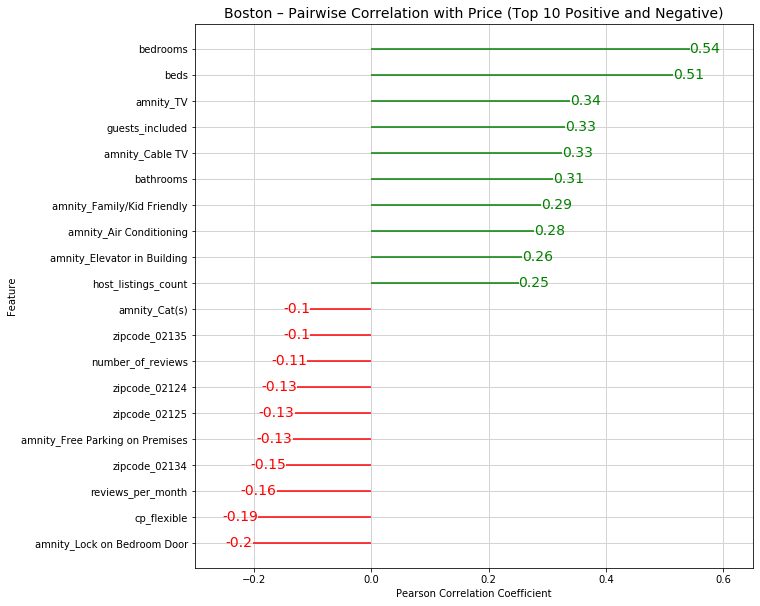

In [146]:
# Plot top correlation features

boston_corr_df['colors'] = ['red' if x < 0 else 'green' for x in boston_corr_df['corr']]

fig, ax = plt.subplots(figsize=(10, 10))
ax.invert_yaxis()

ax.hlines(y=boston_corr_df.index, xmin=0, xmax=boston_corr_df["corr"], color=boston_corr_df["colors"])
for x, y, tex in zip(boston_corr_df["corr"], boston_corr_df.index, boston_corr_df["corr"]):
    t = plt.text(x, y, round(tex, 2), horizontalalignment='right' if x < 0 else 'left', 
                 verticalalignment='center', fontdict={'color':'red' if x < 0 else 'green', 'size':14})


plt.xlabel("Pearson Correlation Coefficient")
plt.ylabel("Feature")
plt.title("Boston – Pairwise Correlation with Price (Top 10 Positive and Negative)", fontsize=14) 
ax.grid(color='lightgrey', linestyle='-', linewidth=1)
ax.set_facecolor("white")
plt.xlim(-0.3, 0.65)
plt.savefig('boston_feature_correlation.png', bbox_inches='tight')

## ...in Seattle?

In [117]:
# transform price from string to float using the getFloatPrices column
s_df["price"] = s_df["price"].apply(getFloatPrices)

# cleaning df from na values in columns of interest
print(s_df.shape[0])
s_df_cleaned = s_df[columns_of_interest].dropna()
print(s_df_cleaned.shape[0])
s_df_cleaned = s_df_cleaned.reset_index()
s_df_cleaned

3818
3134


,index,id,latitude,longitude,price,zipcode,bathrooms,bedrooms,beds,bed_type,...,host_total_listings_count,host_identity_verified,review_scores_accuracy,review_scores_location,review_scores_value,review_scores_checkin,review_scores_communication,review_scores_cleanliness,review_scores_rating,reviews_per_month
0,0,241032,47.636289,-122.371025,85.0,98119,1.0,1.0,1.0,Real Bed,...,3.0,t,10.0,9.0,10.0,10.0,10.0,10.0,95.0,4.07
1,1,953595,47.639123,-122.365666,150.0,98119,1.0,1.0,1.0,Real Bed,...,6.0,t,10.0,10.0,10.0,10.0,10.0,10.0,96.0,1.48
2,2,3308979,47.629724,-122.369483,975.0,98119,4.5,5.0,7.0,Real Bed,...,2.0,t,10.0,10.0,10.0,10.0,10.0,10.0,97.0,1.15
3,4,278830,47.632918,-122.372471,450.0,98119,2.0,3.0,3.0,Real Bed,...,2.0,t,9.0,9.0,9.0,10.0,10.0,9.0,92.0,0.89
4,5,5956968,47.630525,-122.366174,120.0,98119,1.0,1.0,1.0,Real Bed,...,1.0,t,10.0,10.0,10.0,10.0,10.0,10.0,95.0,2.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3129,3810,262764,47.654205,-122.352604,154.0,98103,1.0,2.0,3.0,Real Bed,...,1.0,t,9.0,10.0,8.0,10.0,10.0,8.0,92.0,1.56
3130,3811,8578490,47.657898,-122.346692,65.0,98103,1.0,1.0,1.0,Real Bed,...,1.0,t,9.0,10.0,10.0,10.0,10.0,8.0,100.0,0.63
3131,3812,3383329,47.654516,-122.358124,95.0,98107,1.0,1.0,2.0,Real Bed,...,3.0,t,10.0,9.0,10.0,10.0,10.0,10.0,96.0,4.01
3132,3813,8101950,47.664295,-122.359170,359.0,98107,2.0,3.0,3.0,Real Bed,...,354.0,t,8.0,10.0,8.0,4.0,8.0,10.0,80.0,0.30


In [118]:
# checking non-numeric columns for unique features
s_df_features = s_df_cleaned[s_df_cleaned.columns.difference(["index", "id", "latitude", "longitude"])]

for col in s_df_features:
    if(s_df_features[col].dtype == "object"):
        print(F"{col}: {len(set(s_df_features[col]))}")

amenities: 2705
bed_type: 5
cancellation_policy: 3
host_has_profile_pic: 2
host_identity_verified: 2
host_verifications: 80
instant_bookable: 2
zipcode: 28


In [119]:
# print unique entries in bed_type column
bed_type_set = set( s_df_features["bed_type"])

print(len(bed_type_set))

for entry in bed_type_set:
      print(entry)

5
Real Bed
Pull-out Sofa
Airbed
Couch
Futon


In [120]:
# print unique entries in cancellation_policy column
cancellation_policy_set = set( s_df_features["cancellation_policy"])

print(len(cancellation_policy_set))

for entry in cancellation_policy_set:
      print(entry)

3
flexible
strict
moderate


In [121]:
# print unique entries in host_has_profile_pic column
host_has_profile_pic_set = set( s_df_features["host_has_profile_pic"])

print(len(host_has_profile_pic_set))

for entry in host_has_profile_pic_set:
      print(entry)

2
f
t


In [122]:
# print unique entries in host_identity_verified column
host_identity_verified_set = set( s_df_features["host_identity_verified"])

print(len(host_identity_verified_set))

for entry in host_identity_verified_set:
      print(entry)

2
f
t


In [123]:
# print unique entries in instant_bookable column
instant_bookable_set = set( s_df_features["instant_bookable"])

print(len(instant_bookable_set))

for entry in instant_bookable_set:
      print(entry)

2
f
t


In [124]:
# print unique entries in amnities column
amnity_list = []

for i in range(0, s_df_features.shape[0]):
    amnity_row = s_df_features["amenities"][i].split(",")
    for element in amnity_row:
        element = element.replace('"', '').replace('{', '').replace('}', '')
        amnity_list.append(element)

amnity_set = set(amnity_list)
amnity_set.remove("")

print(len(amnity_set))

for entry in amnity_set:
      print(entry)

41
Internet
Dog(s)
Lock on Bedroom Door
Essentials
Pets Allowed
Cat(s)
Carbon Monoxide Detector
Hangers
Wheelchair Accessible
Pool
Smoke Detector
Safety Card
First Aid Kit
Buzzer/Wireless Intercom
Washer
Heating
Iron
Washer / Dryer
Kitchen
Doorman
24-Hour Check-in
Hot Tub
Laptop Friendly Workspace
Cable TV
Wireless Internet
Air Conditioning
Pets live on this property
Smoking Allowed
Dryer
Other pet(s)
Indoor Fireplace
Family/Kid Friendly
Hair Dryer
TV
Elevator in Building
Fire Extinguisher
Shampoo
Gym
Free Parking on Premises
Breakfast
Suitable for Events


In [125]:
# print unique entries in host_verification column
host_verifications_list = []

for i in range(0, s_df_features.shape[0]):
    host_verifications_row = s_df_features["host_verifications"][i].split(",")
    for element in host_verifications_row:
        element = element.replace('[', '').replace(']', '').replace("'", '').strip()
        host_verifications_list.append(element)
        
host_verifications_set = set(host_verifications_list)

print(len(host_verifications_set))

for entry in host_verifications_set:
      print(entry)

14
weibo
phone
google
jumio
manual_online
kba
facebook
manual_offline
sent_id
photographer
amex
reviews
linkedin
email


In [126]:
# print unique entries in zipcode column
zip_code_set = set( s_df_features["zipcode"])

print(len(zip_code_set))

for entry in zip_code_set:
      print(entry)

28
98199
98104
98126
98108
98112
98109
98177
98118
98103
98178
98106
98117
98122
98144
99
98122
98125
98101
98134
98115
98133
98107
98136
98105
98102
98116
98146
98121
98119


In [ ]:
# get all numeric columns and append them to a list
num_cols = []

for col in s_df_features.columns:
    if(s_df_features[col].dtype == "object"):
        continue
    else:
        print(s_df_features[col].dtype)
        num_cols.append(col)

In [127]:
# create dummy columns for non numeric columns

non_numeric_cols = [] 

for element in list(amnity_set):
    non_numeric_cols.append(F"{element}")
    s_df_features[F"amnity_{element}"] = 0
    
for element in list(host_verifications_set):
    non_numeric_cols.append(F"{element}")
    s_df_features[F"hv_{element}"] = 0
    
for element in list(zip_code_set):
    non_numeric_cols.append(F"{element}")
    s_df_features[F"zipcode_{element}"] = 0

for element in list(bed_type_set):
    non_numeric_cols.append(F"{element}")
    s_df_features[F"bt_{element}"] = 0
    
for element in list(cancellation_policy_set):
    non_numeric_cols.append(F"{element}")
    s_df_features[F"cp_{element}"] = 0
    
for element in list(host_has_profile_pic_set):
    non_numeric_cols.append(F"{element}")
    s_df_features[F"hpc_{element}"] = 0
    
for element in list(host_identity_verified_set):
    non_numeric_cols.append(F"{element}")
    s_df_features[F"hiv_{element}"] = 0
    
for element in list(instant_bookable_set):
    non_numeric_cols.append(F"{element}")
    s_df_features[F"ib_{element}"] = 0
    
s_df_features

float64
float64
float64
int64
float64
float64
int64
float64
float64
float64
float64
float64
float64
float64
float64
float64


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,guests_included,host_has_profile_pic,host_identity_verified,host_listings_count,...,bt_Futon,cp_flexible,cp_strict,cp_moderate,hpc_f,hpc_t,hiv_f,hiv_t,ib_f,ib_t
0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,moderate,2,t,t,3.0,...,0,0,0,0,0,0,0,0,0,0
1,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",1.0,Real Bed,1.0,1.0,strict,1,t,t,6.0,...,0,0,0,0,0,0,0,0,0,0
2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",4.5,Real Bed,5.0,7.0,strict,10,t,t,2.0,...,0,0,0,0,0,0,0,0,0,0
3,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",2.0,Real Bed,3.0,3.0,strict,6,t,t,2.0,...,0,0,0,0,0,0,0,0,0,0
4,"{""Wireless Internet"",""Free Parking on Premises...",1.0,Real Bed,1.0,1.0,strict,1,t,t,1.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3129,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",1.0,Real Bed,2.0,3.0,strict,4,t,t,1.0,...,0,0,0,0,0,0,0,0,0,0
3130,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,moderate,1,t,t,1.0,...,0,0,0,0,0,0,0,0,0,0
3131,"{Internet,""Wireless Internet"",Kitchen,""Free Pa...",1.0,Real Bed,1.0,2.0,moderate,2,t,t,3.0,...,0,0,0,0,0,0,0,0,0,0
3132,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",2.0,Real Bed,3.0,3.0,strict,1,t,t,354.0,...,0,0,0,0,0,0,0,0,0,0


In [128]:
s_df_features.iloc[:, 24:]

,amnity_Internet,amnity_Dog(s),amnity_Lock on Bedroom Door,amnity_Essentials,amnity_Pets Allowed,amnity_Cat(s),amnity_Carbon Monoxide Detector,amnity_Hangers,amnity_Wheelchair Accessible,amnity_Pool,...,bt_Futon,cp_flexible,cp_strict,cp_moderate,hpc_f,hpc_t,hiv_f,hiv_t,ib_f,ib_t
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3129,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3130,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3131,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3132,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [129]:
# For each new features column, write 1 if "original column" has entry, write 0 if not

for col in s_df_features.iloc[:, 24:]:
    
    if "amnity" in col: 
        print(col)
        for i in range(0, s_df_features.shape[0]):
            if col[7:] in s_df_features["amenities"][i]:
                s_df_features[col][i] = 1
            else:
                s_df_features[col][i] = 0
    elif "zipcode" in col:
        print(col)
        for i in range(0, s_df_features.shape[0]):
            if col[8:] in s_df_features["zipcode"][i]:
                s_df_features[col][i] = 1
            else:
                s_df_features[col][i] = 0
                
    elif "hv_" in col:
        print(col)
        for i in range(0, s_df_features.shape[0]):
            if col[3:] in s_df_features["host_verifications"][i]:
                s_df_features[col][i] = 1
            else:
                s_df_features[col][i] = 0
                
    elif "bt_" in col:
        print(col)
        for i in range(0, s_df_features.shape[0]):
            if col[3:] in s_df_features["bed_type"][i]:
                s_df_features[col][i] = 1
            else:
                s_df_features[col][i] = 0                
                
    elif "cp_" in col:
        print(col)
        for i in range(0, s_df_features.shape[0]):
            if col[3:] in s_df_features["cancellation_policy"][i]:
                s_df_features[col][i] = 1
            else:
                s_df_features[col][i] = 0               
                
    elif "hpc_" in col:
        print(col)
        for i in range(0, s_df_features.shape[0]):
            if col[4:] in s_df_features["host_has_profile_pic"][i]:
                s_df_features[col][i] = 1
            else:
                s_df_features[col][i] = 0
                                
    elif "hiv_" in col:
        print(col)
        for i in range(0, s_df_features.shape[0]):
            if col[4:] in s_df_features["host_identity_verified"][i]:
                s_df_features[col][i] = 1
            else:
                s_df_features[col][i] = 0
                
    elif "ib_" in col:
        print(col)
        for i in range(0, s_df_features.shape[0]):
            if col[3:] in s_df_features["instant_bookable"][i]:
                s_df_features[col][i] = 1
            else:
                s_df_features[col][i] = 0

nums = []
non_nums = []

for col in s_df_features.columns:
    if(s_df_features[col].dtype == "object"):
        non_nums.append(col)
    else:
        nums.append(col)
        
        

s_df_features_numeric = s_df_features[nums]
s_df_features_numeric

amnity_Internet


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


amnity_Dog(s)
amnity_Lock on Bedroom Door
amnity_Essentials
amnity_Pets Allowed
amnity_Cat(s)
amnity_Carbon Monoxide Detector
amnity_Hangers
amnity_Wheelchair Accessible
amnity_Pool
amnity_Smoke Detector
amnity_Safety Card
amnity_First Aid Kit
amnity_Buzzer/Wireless Intercom
amnity_Washer
amnity_Heating
amnity_Iron
amnity_Washer / Dryer
amnity_Kitchen
amnity_Doorman
amnity_24-Hour Check-in
amnity_Hot Tub
amnity_Laptop Friendly Workspace
amnity_Cable TV
amnity_Wireless Internet
amnity_Air Conditioning
amnity_Pets live on this property
amnity_Smoking Allowed
amnity_Dryer
amnity_Other pet(s)
amnity_Indoor Fireplace
amnity_Family/Kid Friendly
amnity_Hair Dryer
amnity_TV
amnity_Elevator in Building
amnity_Fire Extinguisher
amnity_Shampoo
amnity_Gym
amnity_Free Parking on Premises
amnity_Breakfast
amnity_Suitable for Events
hv_weibo


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


hv_phone
hv_google
hv_jumio
hv_manual_online
hv_kba
hv_facebook
hv_manual_offline
hv_sent_id
hv_photographer
hv_amex
hv_reviews
hv_linkedin
hv_email
zipcode_98199


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


zipcode_98104
zipcode_98126
zipcode_98108
zipcode_98112
zipcode_98109
zipcode_98177
zipcode_98118
zipcode_98103
zipcode_98178
zipcode_98106
zipcode_98117
zipcode_98122
zipcode_98144
zipcode_99
98122
zipcode_98125
zipcode_98101
zipcode_98134
zipcode_98115
zipcode_98133
zipcode_98107
zipcode_98136
zipcode_98105
zipcode_98102
zipcode_98116
zipcode_98146
zipcode_98121
zipcode_98119
bt_Real Bed


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


bt_Pull-out Sofa
bt_Airbed
bt_Couch
bt_Futon
cp_flexible


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


cp_strict
cp_moderate
hpc_f


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


hpc_t
hiv_f


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


hiv_t
ib_f


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ib_t


,bathrooms,bedrooms,beds,guests_included,host_listings_count,host_total_listings_count,number_of_reviews,price,review_scores_accuracy,review_scores_checkin,...,bt_Futon,cp_flexible,cp_strict,cp_moderate,hpc_f,hpc_t,hiv_f,hiv_t,ib_f,ib_t
0,1.0,1.0,1.0,2,3.0,3.0,207,85.0,10.0,10.0,...,0,0,0,1,0,1,0,1,1,0
1,1.0,1.0,1.0,1,6.0,6.0,43,150.0,10.0,10.0,...,0,0,1,0,0,1,0,1,1,0
2,4.5,5.0,7.0,10,2.0,2.0,20,975.0,10.0,10.0,...,0,0,1,0,0,1,0,1,1,0
3,2.0,3.0,3.0,6,2.0,2.0,38,450.0,9.0,10.0,...,0,0,1,0,0,1,0,1,1,0
4,1.0,1.0,1.0,1,1.0,1.0,17,120.0,10.0,10.0,...,0,0,1,0,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3129,1.0,2.0,3.0,4,1.0,1.0,5,154.0,9.0,10.0,...,0,0,1,0,0,1,0,1,1,0
3130,1.0,1.0,1.0,1,1.0,1.0,2,65.0,9.0,10.0,...,0,0,0,1,0,1,0,1,1,0
3131,1.0,1.0,2.0,2,3.0,3.0,73,95.0,10.0,10.0,...,0,0,0,1,0,1,0,1,0,1
3132,2.0,3.0,3.0,1,354.0,354.0,1,359.0,8.0,4.0,...,0,0,1,0,0,1,0,1,1,0


In [130]:
#Split into explanatory and response variables
X = s_df_features_numeric.loc[:, s_df_features_numeric.columns != 'price']
y = s_df_features_numeric['price']
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state=90) 
# Fit model
lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)
# Predict data
y_test_preds = lm_model.predict(X_test) 
# Score predictions
y_test_preds = lm_model.predict(X_test)
r2_test = r2_score(y_test, y_test_preds) 
print(r2_test)
rmse_test = mt.sqrt(mean_squared_error(y_test, y_test_preds))
print(rmse_test)

0.5743883599605337
44.14809327850285


In [131]:
# creating correlation dfs

price_correlation_seattle = pd.DataFrame(s_df_features_numeric.corr()["price"])

positive_correlation_seattle = []
positive_correlation_seattle_value = []
for i in price_correlation_seattle.index.tolist():
    if(price_correlation_seattle["price"][i] > 0.1):
        positive_correlation_seattle_value.append(price_correlation_seattle["price"][i])
        positive_correlation_seattle.append(i)

negative_correlation_seattle  =  []
negative_correlation_seattle_value = []
for i in price_correlation_seattle.index.tolist():
    if(price_correlation_seattle["price"][i] < -0.1):
        negative_correlation_seattle_value.append(price_correlation_seattle["price"][i])
        negative_correlation_seattle.append(i)

In [132]:
print(positive_correlation_seattle)

['bathrooms', 'bedrooms', 'beds', 'guests_included', 'price', 'amnity_Pool', 'amnity_Washer', 'amnity_Kitchen', 'amnity_Doorman', 'amnity_Hot Tub', 'amnity_Cable TV', 'amnity_Air Conditioning', 'amnity_Dryer', 'amnity_Indoor Fireplace', 'amnity_Family/Kid Friendly', 'amnity_TV', 'amnity_Elevator in Building', 'amnity_Gym', 'amnity_Suitable for Events', 'zipcode_98101', 'bt_Real Bed', 'cp_strict']


In [133]:
print(negative_correlation_seattle)

['number_of_reviews', 'reviews_per_month', 'amnity_Pets live on this property', 'amnity_Breakfast', 'cp_flexible', 'cp_moderate']


In [134]:
positive_correlation_seattle_value

[0.5186524828343178,
 0.6336079954581554,
 0.5918168347505307,
 0.4216717888554563,
 1.0,
 0.11101628362172562,
 0.12875042775793513,
 0.14840168998917053,
 0.12500359174769357,
 0.14285415296386655,
 0.24159947543415516,
 0.1373183840860423,
 0.11585419320991586,
 0.14794481390506675,
 0.2627652986688485,
 0.23936077065467398,
 0.1131808047016818,
 0.12867381395624664,
 0.10429486734852401,
 0.10193488670856976,
 0.12507625757667845,
 0.24092613806323657]

In [135]:
positive_correlation_seattle

['bathrooms',
 'bedrooms',
 'beds',
 'guests_included',
 'price',
 'amnity_Pool',
 'amnity_Washer',
 'amnity_Kitchen',
 'amnity_Doorman',
 'amnity_Hot Tub',
 'amnity_Cable TV',
 'amnity_Air Conditioning',
 'amnity_Dryer',
 'amnity_Indoor Fireplace',
 'amnity_Family/Kid Friendly',
 'amnity_TV',
 'amnity_Elevator in Building',
 'amnity_Gym',
 'amnity_Suitable for Events',
 'zipcode_98101',
 'bt_Real Bed',
 'cp_strict']

In [136]:
positive_correlation_seattle_df = pd.DataFrame({'feature': positive_correlation_seattle,'corr': positive_correlation_seattle_value}).sort_values(by="corr", ascending=False)
positive_correlation_seattle_df

,feature,corr
4,price,1.000000
1,bedrooms,0.633608
2,beds,0.591817
0,bathrooms,0.518652
3,guests_included,0.421672
14,amnity_Family/Kid Friendly,0.262765
10,amnity_Cable TV,0.241599
21,cp_strict,0.240926
15,amnity_TV,0.239361
7,amnity_Kitchen,0.148402


In [137]:
negative_correlation_seattle_df = pd.DataFrame({'feature': negative_correlation_seattle,'corr': negative_correlation_seattle_value}).sort_values(by="corr", ascending=False)
negative_correlation_seattle_df

,feature,corr
5,cp_moderate,-0.109705
3,amnity_Breakfast,-0.120069
2,amnity_Pets live on this property,-0.130272
0,number_of_reviews,-0.134837
4,cp_flexible,-0.151526
1,reviews_per_month,-0.218607


In [138]:
new_features = positive_correlation_seattle + negative_correlation_seattle
len(new_features)

28

In [139]:


# Testing with reduced features
s_df_reduced_features = s_df_features_numeric[new_features]
s_df_reduced_features

#Split into explanatory and response variables
X = s_df_reduced_features.loc[:, s_df_reduced_features.columns != 'price']
y = s_df_reduced_features['price']
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state=90) 
# Fit model
lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)
# Predict data
y_test_preds = lm_model.predict(X_test) 
# Score predictions
y_test_preds = lm_model.predict(X_test)
r2_test = r2_score(y_test, y_test_preds) 
print(r2_test)
rmse_test = mt.sqrt(mean_squared_error(y_test, y_test_preds))
print(rmse_test)

0.5416950911541186
45.812338129076274


In [140]:
# create a df with all most correlation features 
seattle_corr_df = pd.concat([negative_correlation_seattle_df.head(10).reset_index(), positive_correlation_seattle_df.reset_index()[1:11]])
seattle_corr_df = seattle_corr_df.sort_values(by="corr", ascending=False)
seattle_corr_df.index = seattle_corr_df["feature"]
seattle_corr_df = seattle_corr_df[["corr"]]
seattle_corr_df

,corr
feature,
bedrooms,0.633608
beds,0.591817
bathrooms,0.518652
guests_included,0.421672
amnity_Family/Kid Friendly,0.262765
amnity_Cable TV,0.241599
cp_strict,0.240926
amnity_TV,0.239361
amnity_Kitchen,0.148402


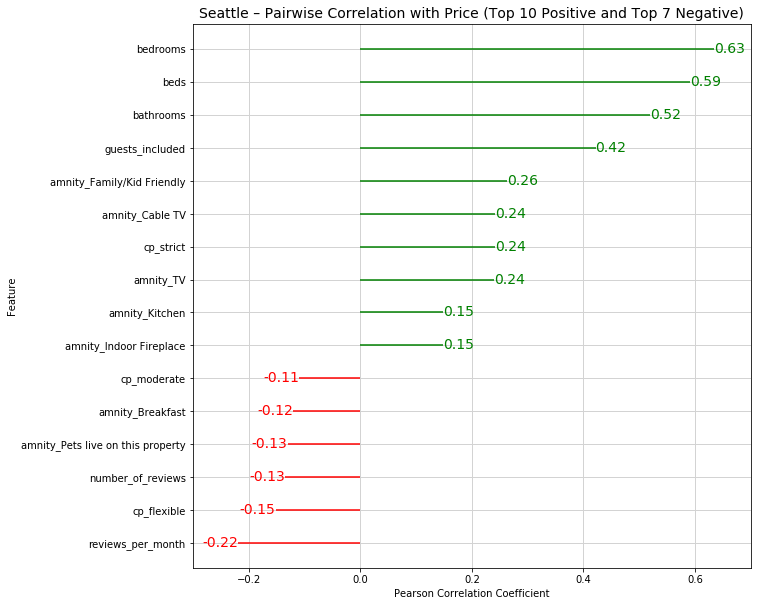

In [145]:
# Plot top correlation features

seattle_corr_df['colors'] = ['red' if x < 0 else 'green' for x in seattle_corr_df['corr']]
# Draw plot

fig, ax = plt.subplots(figsize=(10, 10))
ax.invert_yaxis()

ax.hlines(y=seattle_corr_df.index, xmin=0, xmax=seattle_corr_df["corr"], color=seattle_corr_df["colors"])
for x, y, tex in zip(seattle_corr_df["corr"], seattle_corr_df.index, seattle_corr_df["corr"]):
    t = plt.text(x, y, round(tex, 2), horizontalalignment='right' if x < 0 else 'left', 
                 verticalalignment='center', fontdict={'color':'red' if x < 0 else 'green', 'size':14})


plt.xlabel("Pearson Correlation Coefficient")
plt.ylabel("Feature")
plt.title("Seattle – Pairwise Correlation with Price (Top 10 Positive and Top 7 Negative)", fontsize=14) 
ax.grid(color='lightgrey', linestyle='-', linewidth=1)
ax.set_facecolor("white")
plt.xlim(-0.3, 0.7)

plt.savefig('seattle_feature_correlation.png', bbox_inches='tight')

# 3. Are there specific areas within the cities that are more expensive?

# ... in Boston?

In [134]:
# get zips that correlate positively
positive_correlation_zips = []
for element in positive_correlation:
    if "zipcode_" in element:
        zipcode = element.split("zipcode_")[1]
        positive_correlation_zips.append(zipcode)
positive_correlation_zips

['02114', '02116', '02210', '02111', '02118']

In [135]:
# get zips that correlate negatively
negative_correlation_zips = []
for element in negative_correlation:
    if "zipcode_" in element:
        zipcode = element.split("zipcode_")[1]
        negative_correlation_zips.append(zipcode)
negative_correlation_zips

['02134', '02135', '02125', '02124']

In [136]:
# Merge both
correlation_zips = positive_correlation_zips + negative_correlation_zips
correlation_zips

['02114',
 '02116',
 '02210',
 '02111',
 '02118',
 '02134',
 '02135',
 '02125',
 '02124']

In [137]:
# Show counted values per zip code
print(b_df.shape[0])
b_df_corr_zips = b_df.dropna(subset=['zipcode']).reset_index()
print(b_df_corr_zips.shape[0])
#b_df_corr_zips = b_df_corr_zips.loc[b_df_corr_zips["zipcode"].isin(correlation_zips)].reset_index()
print(b_df_corr_zips["zipcode"].value_counts())

3585
3547
02116          388
02130          331
02118          247
02215          236
02134          232
02114          231
02127          180
02135          172
02115          169
02128          146
02125          129
02120          115
02113          101
02119          100
02111           99
02129           90
02124           80
02210           75
02108           72
02131           65
02109           51
02122           44
02132           37
02121           29
02136           29
02126           24
02110           13
02145           12
02446            8
02143            7
02138            6
02139            6
02445            5
02467            5
02163            3
02141            3
02218            1
02186            1
02472            1
02169            1
02108 02111      1
02134-1704       1
02142            1
Name: zipcode, dtype: int64


In [138]:
# Create correlation columns and write value based correlating zip codes

b_df_corr_zips["correlation"] = None

for i in range(0, b_df_corr_zips.shape[0]):
    if(b_df_corr_zips['zipcode'][i] in positive_correlation_zips):
        b_df_corr_zips["correlation"][i] = "positive"
    elif(b_df_corr_zips['zipcode'][i] in negative_correlation_zips):
        b_df_corr_zips["correlation"][i] = "negative"
    else:
        b_df_corr_zips["correlation"][i] = "no correlation"

    
b_df_corr_zips.head(3)
print(b_df_corr_zips["correlation"].value_counts())
#s_df_corr_zips["price"] = s_df_corr_zips["price"].apply(getFloatPrices)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


no correlation    1894
positive          1040
negative           613
Name: correlation, dtype: int64


In [ ]:
s_geo = s_df_corr_zips[["id", "price", "latitude", "longitude", "correlation"]]

gdf_seattle = geopandas.GeoDataFrame(
    s_geo, geometry=geopandas.points_from_xy(s_geo["longitude"], s_geo["latitude"]))

# creating color map for categories
categories = np.unique(s_geo["correlation"])
colors = np.linspace(0, 1, len(categories))
colordict = dict(zip(categories, colors))

gdf_seattle["Color"] = gdf_seattle["correlation"].apply(lambda x: colordict[x])

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["orange","red"])

ax1 = seattle.plot(figsize=(16, 14), alpha=0.3, edgecolor='black', color='lightgrey')
ax1.grid(color='black', alpha=0.1, linestyle='-', linewidth=1)
ax1.set_facecolor('white')
ax1.set_title("Seattle – AirBnB Listings by ZIP-Price-Correlation", fontsize=20)
ax1.legend(b_df_corr_zips['correlation'])
gdf_seattle.plot(ax=ax1, marker='o', alpha=0.3, legend=True, column='correlation', cmap=cmap)

plt.savefig('seattle_corr_map.png')

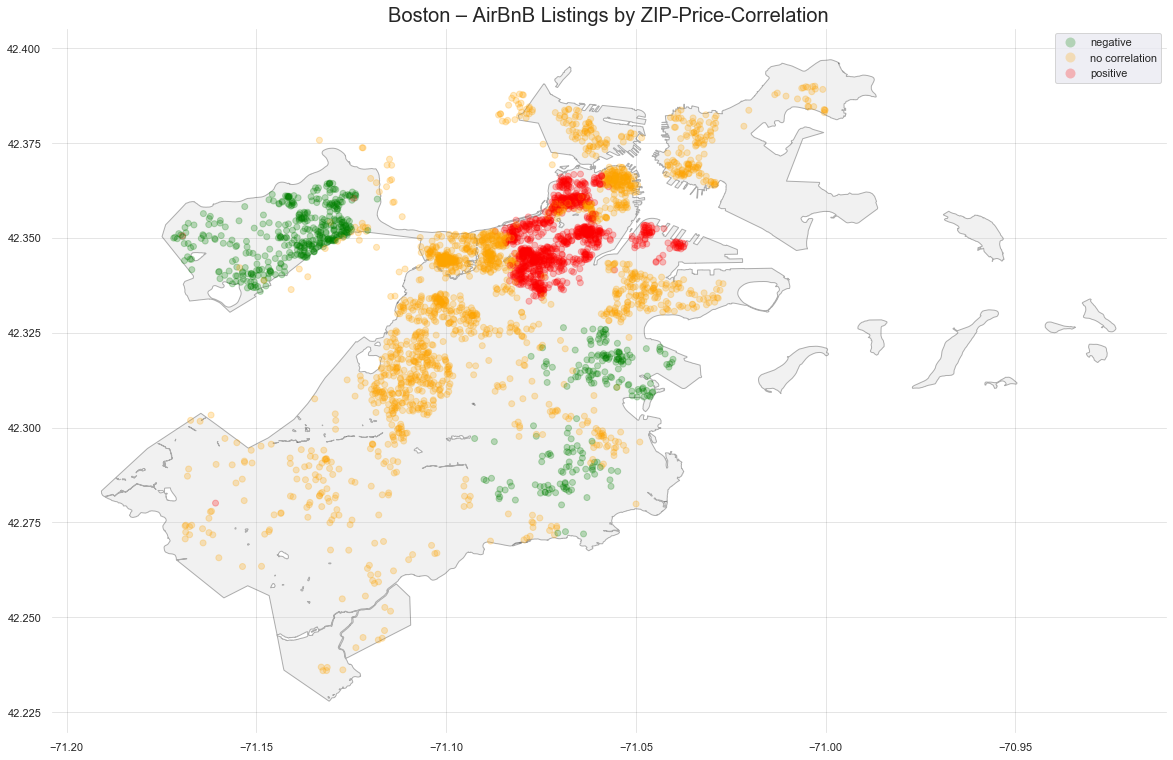

In [539]:
b_geo = b_df_corr_zips[["id", "price", "latitude", "longitude", "correlation"]]

gdf_boston = geopandas.GeoDataFrame(
    b_geo, geometry=geopandas.points_from_xy(b_geo["longitude"], b_geo["latitude"]))

# creating color map for categories
categories = np.unique(b_geo["correlation"])
colors = np.linspace(0, 1, len(categories))
colordict = dict(zip(categories, colors))

gdf_boston["Color"] = gdf_boston["correlation"].apply(lambda x: colordict[x])

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green", "orange","red"])

ax1 = boston.plot(figsize=(20, 14), alpha=0.3, edgecolor='black', color='lightgrey')
ax1.grid(color='black', alpha=0.1, linestyle='-', linewidth=1)
ax1.set_facecolor('white')
ax1.set_title("Boston – AirBnB Listings by ZIP-Price-Correlation", fontsize=20)
gdf_boston.plot(ax=ax1, marker='o', alpha=0.25, legend=True, column='correlation', cmap=cmap)
plt.savefig('boston_corr_map.png')

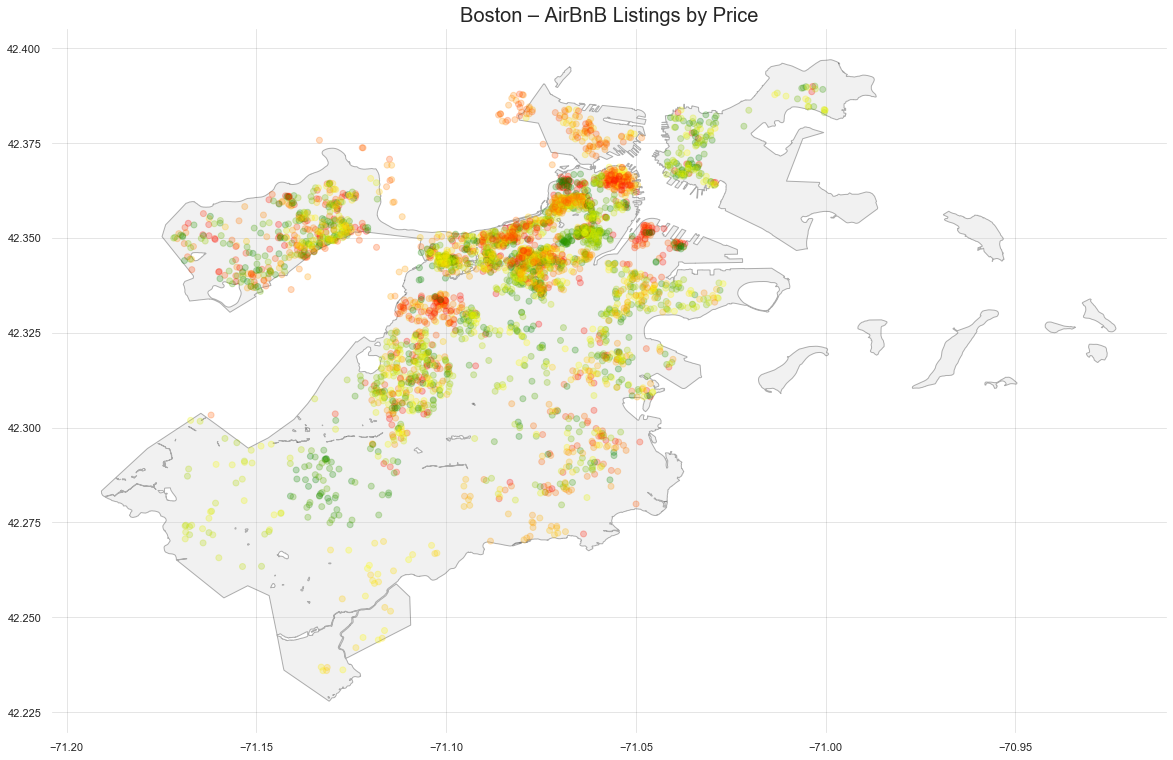

In [192]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","yellow","red"])
ax2 = boston.plot(figsize=(20, 14), alpha=0.3, edgecolor='black', color='lightgrey')
ax2.grid(color='black', alpha=0.1, linestyle='-', linewidth=1)
ax2.set_facecolor('white')
ax2.set_title("Boston – AirBnB Listings by Price", fontsize=20)
gdf_boston.plot(ax=ax2, alpha=0.25, c=gdf_boston["price"], cmap=cmap)
plt.savefig('boston_price_map.png')

# ... in Seattle?

In [141]:
# get zips that correlate positively
positive_correlation_zips = []
for element in positive_correlation_seattle:
    if "zipcode_" in element:
        zipcode = element.split("zipcode_")[1]
        positive_correlation_zips.append(zipcode)
positive_correlation_zips

['98101']

In [142]:
# get zips that correlate negatively
negative_correlation_zips = []
for element in negative_correlation_seattle:
    if "zipcode_" in element:
        zipcode = element.split("zipcode_")[1]
        negative_correlation_zips.append(zipcode)
negative_correlation_zips

[]

In [143]:
# Merge both
correlation_zips = positive_correlation_zips + negative_correlation_zips
correlation_zips

['98101']

In [144]:
# Show counted values per zip code
print(s_df.shape[0])
s_df_corr_zips = s_df.dropna(subset=['zipcode']).reset_index()
print(s_df_corr_zips.shape[0])
#s_df_corr_zips = s_df_corr_zips.loc[s_df_corr_zips["zipcode"] == correlation_zips[0]].reset_index()
print(s_df_corr_zips["zipcode"].value_counts())

3818
3811
98122        420
98103        394
98102        339
98105        225
98109        202
98101        201
98144        200
98121        196
98107        180
98115        178
98112        167
98117        164
98118        154
98119        143
98116        112
98104         95
98125         71
98199         66
98126         63
98106         58
98108         56
98133         46
98136         44
98177         19
98178          7
98146          5
98134          5
99\n98122      1
Name: zipcode, dtype: int64


In [145]:
# Create correlation columns and write value based correlating zip codes

s_df_corr_zips["correlation"] = None

for i in range(0, s_df_corr_zips.shape[0]):
    if(s_df_corr_zips['zipcode'][i] in positive_correlation_zips):
        s_df_corr_zips["correlation"][i] = "positive"
    elif(s_df_corr_zips['zipcode'][i] in negative_correlation_zips):
        s_df_corr_zips["correlation"][i] = "negative"
    else:
        s_df_corr_zips["correlation"][i] = "no correlation"

    
s_df_corr_zips.head(3)
print(s_df_corr_zips["correlation"].value_counts())
#s_df_corr_zips["price"] = s_df_corr_zips["price"].apply(getFloatPrices)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


no correlation    3610
positive           201
Name: correlation, dtype: int64


In [172]:
s_geo = s_df_corr_zips[["id", "price", "latitude", "longitude", "correlation"]]

gdf_seattle = geopandas.GeoDataFrame(
    s_geo, geometry=geopandas.points_from_xy(s_geo["longitude"], s_geo["latitude"]))

# creating color map for categories
categories = np.unique(s_geo["correlation"])
colors = np.linspace(0, 1, len(categories))
colordict = dict(zip(categories, colors))
colordict

{'no correlation': 0.0, 'positive': 1.0}

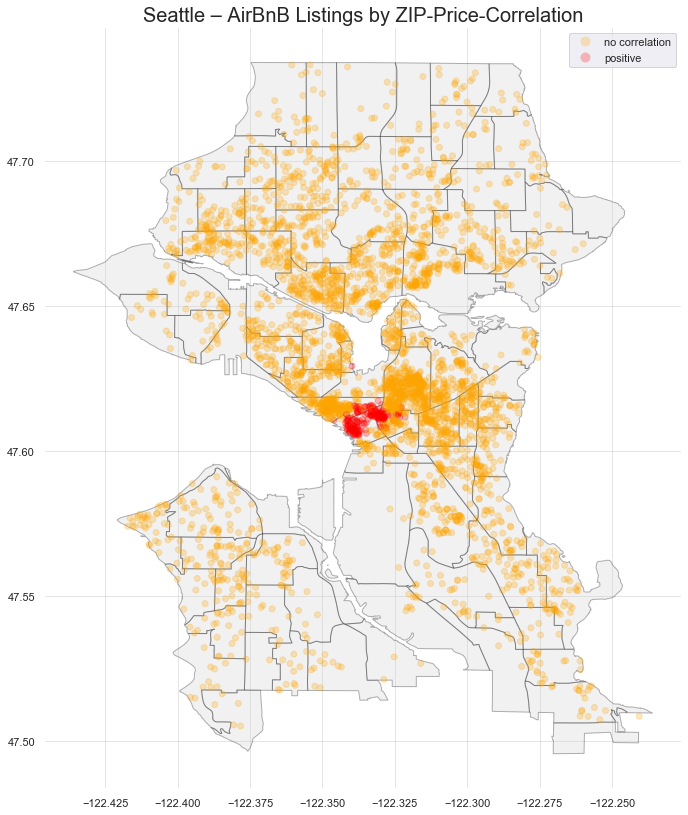

In [193]:
s_geo = s_df_corr_zips[["id", "price", "latitude", "longitude", "correlation"]]

gdf_seattle = geopandas.GeoDataFrame(
    s_geo, geometry=geopandas.points_from_xy(s_geo["longitude"], s_geo["latitude"]))

# creating color map for categories
categories = np.unique(s_geo["correlation"])
colors = np.linspace(0, 1, len(categories))
colordict = dict(zip(categories, colors))

gdf_seattle["Color"] = gdf_seattle["correlation"].apply(lambda x: colordict[x])

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["orange","red"])

ax1 = seattle.plot(figsize=(16, 14), alpha=0.3, edgecolor='black', color='lightgrey')
ax1.grid(color='black', alpha=0.1, linestyle='-', linewidth=1)
ax1.set_facecolor('white')
ax1.set_title("Seattle – AirBnB Listings by ZIP-Price-Correlation", fontsize=20)
ax1.legend(b_df_corr_zips['correlation'])
gdf_seattle.plot(ax=ax1, marker='o', alpha=0.25, legend=True, column='correlation', cmap=cmap)

plt.savefig('seattle_corr_map.png')

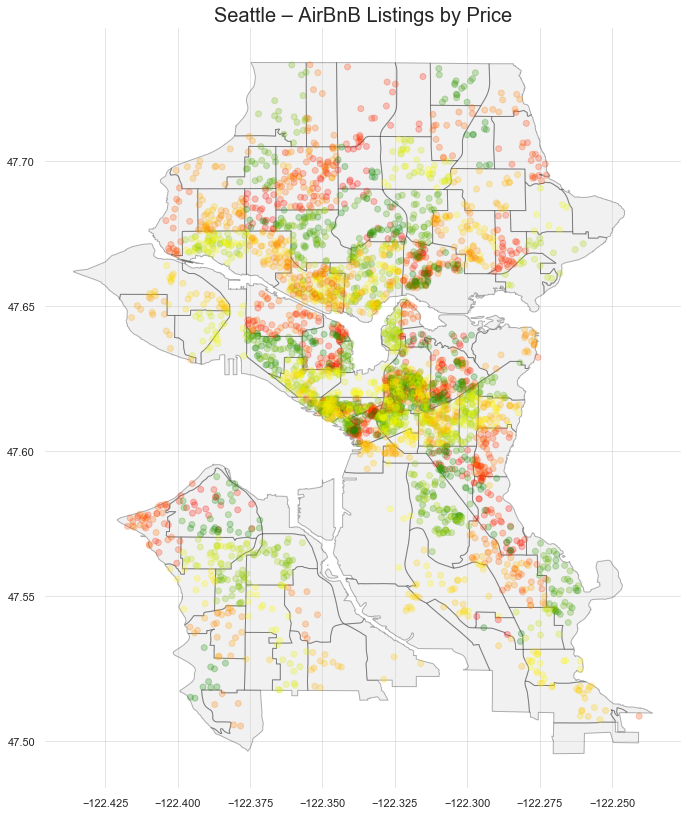

In [194]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","yellow","red"])
ax2 = seattle.plot(figsize=(16, 14), alpha=0.3, edgecolor='black', color='lightgrey')
ax2.grid(color='black', alpha=0.1, linestyle='-', linewidth=1)
ax2.set_facecolor('white')
ax2.set_title("Seattle – AirBnB Listings by Price", fontsize=20)
gdf_seattle.plot(ax=ax2, alpha=0.25, c=gdf_seattle["price"], cmap=cmap)
plt.savefig('seattle_price_map.png')